<a href="https://colab.research.google.com/github/DevinDaughtry/BME3053C-Final-Project/blob/main/HRV_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Heart Rate Variability (HRV) Analysis from PPG

This notebook demonstrates how to analyze heart rate variability (HRV) using a photoplethysmogram (PPG) signal.

We will:
1. Load a publicly available PPG signal from PhysioNet
2. Filter the raw PPG signal
3. Detect heartbeat peaks
4. Compute RR intervals (time between heartbeats)
5. Extract time-domain HRV features (e.g., RMSSD, SDNN, pNN50)
6. Estimate stress level from RMSSD

---

### Biomedical Relevance

Heart Rate Variability (HRV) is a non-invasive biomarker of **autonomic nervous system (ANS)** activity.  
It can provide insight into **stress**, **fatigue**, and **cardiovascular health**.

In [37]:
# Install the wfdb package for working with PhysioNet data
!pip install wfdb

# Import necessary libraries
import wfdb # To read PhysioNet waveform data
import numpy as np # For numerical operations
import matplotlib.pyplot as plt # For plotting
from scipy.signal import butter, filtfilt, find_peaks # Signal filtering & peak detection

In [38]:
# Load a sample record from the PhysioNet BIDMC dataset
record = 'bidmc01' # Record name
pn_dir = 'bidmc' # Dataset directory name on PhysioNet

# Read the signal and metadata
signals, fields = wfdb.rdsamp(record, pn_dir=pn_dir)

# Extract PPG signal (typically column 1 in BIDMC)
ppg_signal = signals[:, 1]
fs = fields['fs'] # Sampling frequency

print(f"Loaded {record} with shape {ppg_signal.shape} at {fs} Hz")

Loaded bidmc01 with shape (60001,) at 125 Hz


In [39]:
# Function to perform bandpass filtering (to remove baseline wander and high-frequency noise)
def bandpass_filter(signal, lowcut, highcut, fs, order=3):
    nyquist = 0.5 * fs # Nyquist frequency
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band') # Design Butterworth filter
    return filtfilt(b, a, signal) # Apply zero-phase filter

# Filter between 0.5–5 Hz to isolate heart-rate-related components
lowcut = 0.5
highcut = 5.0
ppg_filtered = bandpass_filter(ppg_signal, lowcut, highcut, fs)

print(f"Filtered signal shape: {ppg_filtered.shape}")

Filtered signal shape: (60001,)


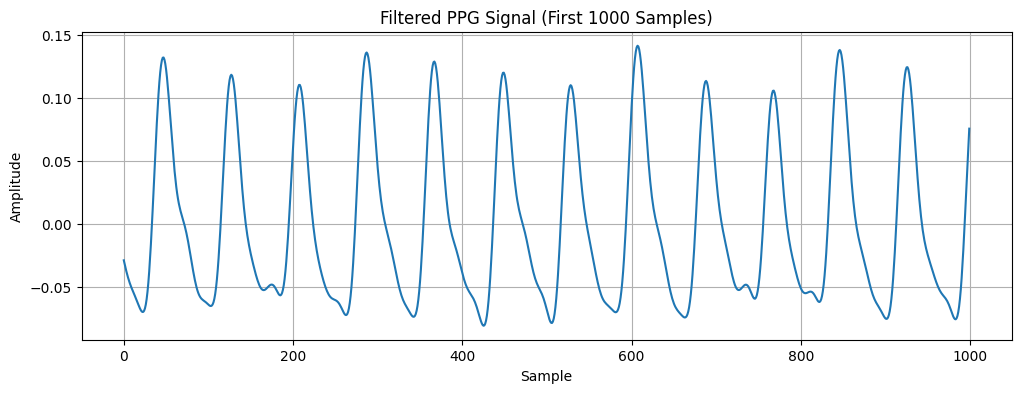

In [40]:
# Plot the first 1000 samples of the filtered PPG signal
plt.figure(figsize=(12, 4))
plt.plot(ppg_filtered[:1000])
plt.title('Filtered PPG Signal (First 1000 Samples)')
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.grid()
plt.show()

Total detected peaks in full signal: 712


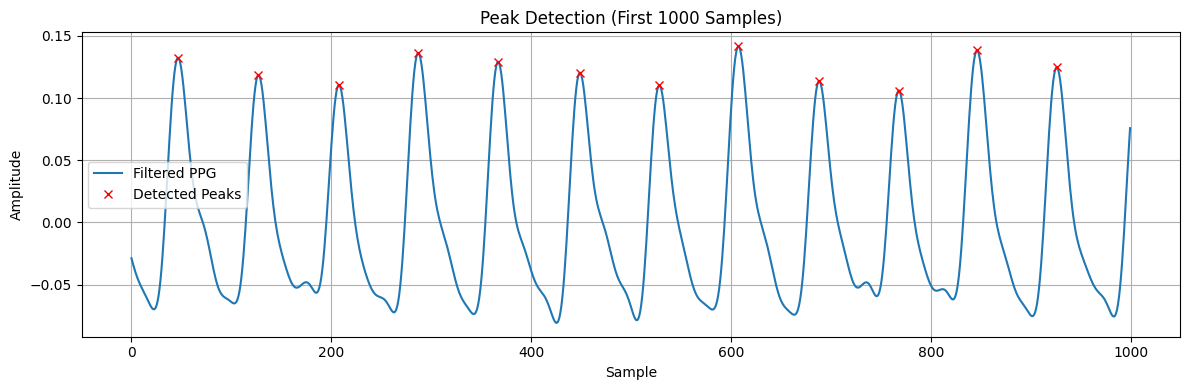

Peaks shown in plot: 12 (out of 712 total)


In [46]:
# Detect peaks with minimum distance and prominence constraints
# distance = minimum number of samples between peaks (~0.5 sec)
# prominence = minimum height difference from surrounding points

import matplotlib.pyplot as plt
from scipy.signal import find_peaks

# --- Loosened peak detection parameters ---
peaks, _ = find_peaks(ppg_filtered, distance=int(fs * 0.4), prominence=0.05)

print(f"Total detected peaks in full signal: {len(peaks)}")

# --- Plot only first 1000 samples ---
samples_to_plot = 1000
subset_peaks = peaks[peaks < samples_to_plot]  # limit to visible range

plt.figure(figsize=(12, 4))
plt.plot(ppg_filtered[:samples_to_plot], label='Filtered PPG')
plt.plot(subset_peaks, ppg_filtered[subset_peaks], 'rx', label='Detected Peaks')
plt.title(f"Peak Detection (First {samples_to_plot} Samples)")
plt.xlabel("Sample")
plt.ylabel("Amplitude")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print(f"Peaks shown in plot: {len(subset_peaks)} (out of {len(peaks)} total)")

Computed 711 RR intervals


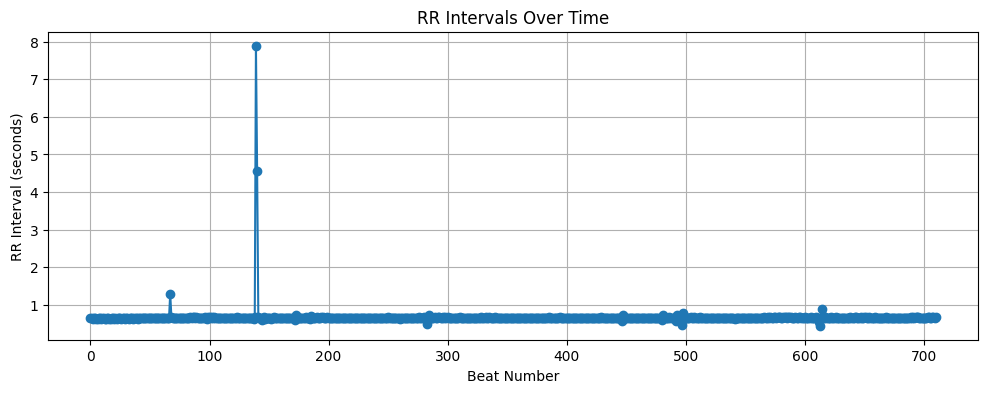

In [47]:
# Convert peak indices to time in seconds
peak_times = peaks / fs

# Compute RR intervals = time between successive heartbeats
rr_intervals = np.diff(peak_times)

print(f"Computed {len(rr_intervals)} RR intervals")

# Plot RR intervals over time to visualize heart rate variability
plt.figure(figsize=(12, 4))
plt.plot(rr_intervals, marker='o')
plt.title('RR Intervals Over Time')
plt.xlabel('Beat Number')
plt.ylabel('RR Interval (seconds)')
plt.grid()
plt.show()

In [49]:
# Clean RR intervals by removing large outliers before HRV analysis

import numpy as np

# OPTIONAL: Print before filtering to compare
print(f"Original RR intervals count: {len(rr_intervals)}")

# 1. Compute median RR interval
median_rr = np.median(rr_intervals)

# 2. Filter out intervals that are greater than 1.5x the median (or other logic as needed)
filtered_rr = rr_intervals[rr_intervals < 1.5 * median_rr]

print(f"Filtered RR intervals count: {len(filtered_rr)}")

# 3. HRV Metrics
# RMSSD = Root Mean Square of Successive Differences
rmssd = np.sqrt(np.mean(np.diff(filtered_rr) ** 2))
# SDNN = Standard Deviation of RR Intervals
sdnn = np.std(filtered_rr)
# pNN50 = Percentage of successive RR intervals differing by >50 ms
nn50 = np.sum(np.abs(np.diff(filtered_rr)) > 0.05)
pnn50 = 100.0 * nn50 / len(filtered_rr)

print(f"\nRMSSD: {rmssd:.4f} sec")
print(f"SDNN: {sdnn:.4f} sec")
print(f"pNN50: {pnn50:.2f}%")

Original RR intervals count: 711
Filtered RR intervals count: 708

RMSSD: 0.0312 sec
SDNN: 0.0207 sec
pNN50: 2.97%


In [56]:
# Simple stress estimation logic based on RMSSD thresholds
# You can customize these values based on literature or dataset

def estimate_stress_literature(rmssd_value):
    """
    Estimate stress level based on RMSSD using thresholds from
    Shaffer & Ginsberg (2017) - Frontiers in Public Health.

    Thresholds:
    - High Stress: RMSSD < 0.02 sec
    - Moderate Stress: 0.02 ≤ RMSSD < 0.04 sec
    - Low Stress: RMSSD ≥ 0.04 sec
    """
    if rmssd_value < 0.02:
        return 'High Stress'
    elif rmssd_value < 0.04:
        return 'Moderate Stress'
    else:
        return 'Low Stress'

stress_level = estimate_stress_literature(rmssd)
print(f"Estimated Stress Level: {stress_level}")

Estimated Stress Level: Moderate Stress


In [58]:
import pandas as pd

# Final stress classification
stress_level = estimate_stress_literature(rmssd)

# Create a summary table
summary_data = {
    'Metric': ['RMSSD (s)', 'SDNN (s)', 'pNN50 (%)', 'Stress Level'],
    'Value': [f"{rmssd:.4f}", f"{sdnn:.4f}", f"{pnn50:.2f}", stress_level]
}

summary_df = pd.DataFrame(summary_data)

# Display the table
print("Final HRV Metrics Summary:\n")
display(summary_df)

Final HRV Metrics Summary:



,Metric,Value
0,RMSSD (s),0.0312
1,SDNN (s),0.0207
2,pNN50 (%),2.97
3,Stress Level,Moderate Stress


## Summary: Heart Rate Variability & Stress Estimation

This project analyzed heart rate variability (HRV) using photoplethysmographic (PPG) data from PhysioNet `bidmc01` to estimate physiological stress levels. The workflow included:

- **Preprocessing** of raw PPG signals using a Butterworth bandpass filter
- **Peak detection** to identify individual heartbeats
- **RR interval calculation** as the time between consecutive peaks
- **HRV metric computation**, including:
  - **RMSSD**: Reflects short-term heart rate variability and parasympathetic activity
  - **SDNN**: Standard deviation of RR intervals, representing overall HRV
  - **pNN50**: Percentage of successive RR intervals differing by more than 50ms

To estimate stress, we applied a logic model based on the **RMSSD** metric, following threshold guidelines adapted from:

> **Shaffer, F., & Ginsberg, J. P. (2017)**.  
> *An Overview of Heart Rate Variability Metrics and Norms*.  
> *Frontiers in Public Health*. [https://doi.org/10.3389/fpubh.2017.00258](https://doi.org/10.3389/fpubh.2017.00258)

### Stress Classification Thresholds (based on RMSSD):
- **High Stress**: RMSSD < 0.02 sec  
- **Moderate Stress**: 0.02 ≤ RMSSD < 0.04 sec  
- **Low Stress**: RMSSD ≥ 0.04 sec  

The final stress classification is computed and displayed accordingly. This approach enables non-invasive, real-time stress monitoring using low-cost wearable sensors and signal processing techniques.

---
